In [2]:
info = """
模块 16：LangGraph 基础
学习如何使用 LangGraph 创建状态图工作流
"""
print(info)


模块 16：LangGraph 基础
学习如何使用 LangGraph 创建状态图工作流



In [3]:
import os
from typing import TypedDict,Annotated,Literal
from dotenv import load_dotenv


In [4]:
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage,AIMessage,SystemMessage

In [5]:
# 加载环境变量
load_dotenv()
GROQ_API_KEY = os.getenv("GROQ_API_KEY")

if not GROQ_API_KEY or GROQ_API_KEY == "your_groq_api_key_here":
    raise ValueError(
        "\n请先在 .env 文件中设置有效的 GROQ_API_KEY\n"
        "访问 https://console.groq.com/keys 获取免费密钥"
    )

In [6]:
# 初始化模型
model = init_chat_model("groq:llama-3.3-70b-versatile", api_key=GROQ_API_KEY)


In [7]:
print(    """
    最简单的 LangGraph 示例：顺序执行的节点
    流程：START -> 预处理 -> LLM处理 -> 后处理 -> END
    """)


    最简单的 LangGraph 示例：顺序执行的节点
    流程：START -> 预处理 -> LLM处理 -> 后处理 -> END
    


In [8]:
print("\n" + "=" * 60)
print("示例 1：简单顺序工作流")
print("=" * 60)



示例 1：简单顺序工作流


In [42]:
# 定义状态图
class SimpleState(TypedDict):
    input_text: str
    processed_text: str
    llm_response: str
    final_output: str
    
    

In [43]:
# 定义节点函数
def preprocess(state: SimpleState) -> dict:
    '''预处理节点：清理和格式化输入'''
    text = state['input_text'].strip().lower()
    print(f"  [预处理] 输入: '{state['input_text']}' -> '{text}'")
    return {"processed_text": text}


In [44]:
def call_llm(state: SimpleState) -> dict:
    """LLM 节点：调用语言模型"""
    messages = [
        SystemMessage(content="你是一个友好的助手，请简洁回答问题。"),
        HumanMessage(content=state["processed_text"])
    ]
    response = model.invoke(messages)
    print(f"  [LLM] 响应: {response.content[:50]}...")
    return {"llm_response": response.content}

In [45]:
def postprocess(state: SimpleState) -> dict:
    """后处理节点：格式化输出"""
    final = f"✨ AI 回复：{state['llm_response']}"
    print("  [后处理] 完成格式化")
    return {"final_output": final}

In [46]:
# 构建图
graph = StateGraph(SimpleState)

In [47]:
# 添加节点
graph.add_node("preprocess",preprocess)
graph.add_node("call_llm",call_llm)
graph.add_node("postprocess",postprocess)

In [48]:
graph 

In [49]:
# 添加边
graph.add_edge(START,"preprocess")
graph.add_edge("preprocess","call_llm")
graph.add_edge("call_llm","postprocess")
graph.add_edge("postprocess",END)


In [50]:
# 编译图
app = graph.compile()


图结构：START -> preprocess -> call_llm -> postprocess -> END


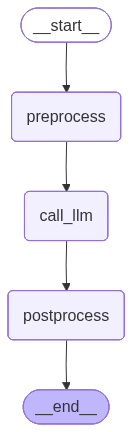

In [51]:
# 可视化图结构（打印）
print("\n图结构：START -> preprocess -> call_llm -> postprocess -> END")
app

In [52]:
# 运行
result = app.invoke({"input_text": "   什么是人工智能？  "})
result

  [预处理] 输入: '   什么是人工智能？  ' -> '什么是人工智能？'
  [LLM] 响应: 人工智能（AI）是指能够像人类一样感知、推理和执行任务的计算机系统，例如学习、解决问题和识别模式。...
  [后处理] 完成格式化


{'input_text': '   什么是人工智能？  ',
 'processed_text': '什么是人工智能？',
 'llm_response': '人工智能（AI）是指能够像人类一样感知、推理和执行任务的计算机系统，例如学习、解决问题和识别模式。',
 'final_output': '✨ AI 回复：人工智能（AI）是指能够像人类一样感知、推理和执行任务的计算机系统，例如学习、解决问题和识别模式。'}

In [53]:
print(f"\n最终输出：\n{result['final_output']}")


最终输出：
✨ AI 回复：人工智能（AI）是指能够像人类一样感知、推理和执行任务的计算机系统，例如学习、解决问题和识别模式。


In [54]:
print("""
    带条件分支的工作流
    根据输入内容选择不同的处理路径
    """)


    带条件分支的工作流
    根据输入内容选择不同的处理路径
    


In [55]:
print("\n" + "=" * 60)
print("示例 2：条件分支工作流")
print("=" * 60)


示例 2：条件分支工作流


In [56]:
class ConditionalState(TypedDict):
    query: str
    query_type:str
    response:str
    

In [57]:
def classify_query(state: ConditionalState) -> dict:
    """分类查询节点：根据查询内容选择处理路径"""
    query = state["query"].lower()
    if any(word in query for word in ["天气","温度","下雨"]):
        return {"query_type": "weather"}
    elif any(word in query for word in ["计算", "加", "减", "乘", "除", "等于"]):
        query_type = "math"
    else:
        query_type = "general"
    print(f"  [分类] 查询类型: {query_type}")
    return {"query_type": query_type}

In [58]:
def handle_weather(state: ConditionalState) -> dict:
    """处理天气查询节点：调用天气 API"""
    # 实际应用中这里会调用天气 API
    response = "🌤️ 今天天气晴朗，温度 25°C，适合外出！"
    return {"response": response}

In [59]:
def handle_math(state: ConditionalState) -> dict:
    """处理数学计算"""
    print("  [数学处理] 执行计算逻辑...")
    messages = [
        SystemMessage(content="你是一个数学助手，请计算并给出结果。"),
        HumanMessage(content=state["query"])
    ]
    result = model.invoke(messages)
    return {"response": f"🔢 {result.content}"}


In [60]:
def handle_general(state: ConditionalState) -> dict:
    """处理一般查询"""
    print("  [通用处理] 执行通用 LLM 调用...")
    messages = [
        SystemMessage(content="你是一个知识渊博的助手，请回答问题。"),
        HumanMessage(content=state["query"])
    ]
    result = model.invoke(messages)
    return {"response": f"💡 {result.content}"}

In [61]:
def route_query(state: ConditionalState) -> Literal["weather", "math", "general"]:
    """路由函数：返回下一个节点名称"""
    return state["query_type"]

In [62]:
# 构建图
graph = StateGraph(ConditionalState)

In [63]:
# 添加节点
graph.add_node("classify", classify_query)
graph.add_node("weather", handle_weather)
graph.add_node("math", handle_math)
graph.add_node("general", handle_general)

In [64]:
# 添加边
graph.add_edge(START, "classify")


In [65]:
graph.add_conditional_edges(
    "classify",
    route_query,
    {
        "weather": "weather",
        "math": "math",
        "general": "general",
    },
)

In [66]:
# 添加结束节点
graph.add_edge("weather",END)
graph.add_edge("math",END)
graph.add_edge("general",END)



图结构：START -> classify -> (weather | math | general) -> END


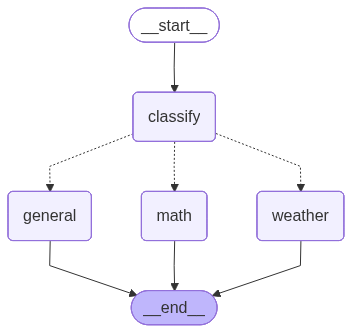

In [69]:
# 编译图
app = graph.compile()
# 可视化图结构（打印）
print("\n图结构：START -> classify -> (weather | math | general) -> END")
app


In [68]:
# 测试不同类型的查询
test_queries = [
    "今天北京的天气怎么样？",
    "计算 123 加 456 等于多少？",
    "Python 是什么编程语言？"
]

for query in test_queries:
    print(f"\n查询: {query}")
    result = app.invoke({"query": query})
    print(f"响应: {result['response'][:100]}...")




查询: 今天北京的天气怎么样？
响应: 🌤️ 今天天气晴朗，温度 25°C，适合外出！...

查询: 计算 123 加 456 等于多少？
  [分类] 查询类型: math
  [数学处理] 执行计算逻辑...
响应: 🔢 123 + 456 = 579...

查询: Python 是什么编程语言？
  [分类] 查询类型: general
  [通用处理] 执行通用 LLM 调用...
响应: 💡 Python是一种高级、解释型编程语言，广泛用于各种领域，如Web开发、科学计算、数据分析、人工智能、自动化等。它以简单、易学、灵活为特点，具有丰富的标准库和第三方库，支持面向对象编程、函数式编程...
